<a href="https://colab.research.google.com/github/viterobk/PythonBasics/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%D0%91%D0%B0%D0%B7%D0%BE%D0%B2%D1%8B%D0%B9_%D0%B1%D0%BB%D0%BE%D0%BA_%7C_%D0%9E%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B0_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%BE%D0%B2_%D1%81_%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D1%85_%D1%81%D0%B5%D1%82%D0%B5%D0%B9_%7C_%D0%94%D0%97_Ultra_Pro_%7C_%D0%A3%D0%98%D0%98%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Дорогой студент!

В домашнем задании Ultra Pro занятия по обработке тектсов с помощью НС мы ставим задачу распознать уже не 6, как ранее, а целых 20 русских писателей! Это подразумевает и больший размер базы для обучения соответственно. Ячейка для скачивания базы уже включена в ноутбук задания.


 В задании необходимо выполнить следующие пункты:

  1. Загрузить саму базу по ссылке и подговить файлы базы для обработки.
  2. Создать обучающую и проверочную выборки, обратив особое внимание на балансировку базы: количество примеров каждого класса должно быть примерно одного порядка. При этом для разбивки необходимо применить цикл. Проверочная выборка должна быть 20% от общей выборки.
  3. Подготовьте выборки для обучения и обучите сеть. Добейтесь результата точности сети не менее 95% на проверочной выборке модели Bag of Words и 75-80% - для модели Embedding.
   


## Загрузка данных

In [ ]:
import gdown                                      # Подключим функцию gdown

def prepare_files():
  print('--- Calling prepare_files()...')
  gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l7/20writers.zip', None, quiet=True)      # Скачивание файла

  !unzip -qo 20writers.zip -d writers/     # Распаковка файлов в папку writers
  #!ls writers

In [2]:
import os
import re

def get_words_dict(dir_name):
  print('--- Calling get_words_dict()...')
  words = {}
  min_length = -1

  # Преобразуем тексты в словарь, где ключ - имя автора, а значение - массив слов из текста
  for file_name in os.listdir(dir_name):
    class_name = file_name[0:-4]
    with open(f'{dir_name}/{file_name}', 'r') as f:
      text = f.read()

    text = re.sub(r'[^\w]', ' ', text, flags=re.UNICODE)
    text = re.sub(r'\s+', ' ', text)
    words[class_name] = text.split()
    length = len(words[class_name])
    if min_length < 0 or min_length > length:
      min_length = length
    #print(f'{class_name} - {len(words[class_name])} слов')

  return words

In [3]:
def get_texts(words):
  print('--- Calling get_texts()...')
  train_texts = {}
  test_texts = {}
  words_count = min(len(value) for value in words.values())

  # Делим массивы слов на обучающую и проверочную выборки (80/20), выравнив количество слов во всех массивах по минимальному значению
  for class_name in words.keys():
    #print(class_name)
    train_words_count = words_count * 80 // 100
    train_texts[class_name] = ' '.join(words[class_name][:train_words_count])
    test_texts[class_name] = ' '.join(words[class_name][train_words_count:words_count])
    #print(f'train - {len(train_texts[class_name].split())} слов')
    #print(f'test - {len(test_texts[class_name].split())} слов')
    #print()

  return train_texts, test_texts

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np

def get_train_and_test_data(train_texts, test_texts, vocabulary_size):
  print('--- Calling get_train_and_test_data()...')
  # Создаем и токенайзер
  tokenizer = Tokenizer(num_words=vocabulary_size, filters='', lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)
  tokenizer.fit_on_texts(train_texts.values())
  #print(list(tokenizer.word_index.items())[:50])
  #print(list(tokenizer.word_index.items())[-50:-1])

  x_train = []
  y_train = []
  x_test = []
  y_test = []

  class_indexes = {key: index for index, key in enumerate(train_texts.keys())}
  class_count = len(class_indexes.keys())

  for class_name in train_texts.keys():
    y = [0] * class_count
    y[class_indexes[class_name]] = 1
    train_sequence = tokenizer.texts_to_sequences([train_texts[class_name]])
    test_sequence = tokenizer.texts_to_sequences([test_texts[class_name]])
    current_x_train = [train_sequence[0][i:i + SEQUENCE_SIZE] for i in range(0, len(train_sequence[0]), SEQUENCE_SIZE // 4)]
    current_x_test = [test_sequence[0][i:i + SEQUENCE_SIZE] for i in range(0, len(test_sequence[0]), SEQUENCE_SIZE)]
    x_train.extend(current_x_train)
    x_test.extend(current_x_test)
    y_train.extend([y] * len(current_x_train))
    y_test.extend([y] * len(current_x_test))

  x_train = tokenizer.sequences_to_matrix(x_train)
  x_test = tokenizer.sequences_to_matrix(x_test)

  # Перемешиваем обучающую выборку
  np.random.seed(42)
  random_train_indicies = np.random.permutation(len(x_train))
  x_train = np.array(x_train)[random_train_indicies]
  y_train = np.array(y_train)[random_train_indicies]

  return x_train, np.array(x_test), y_train, np.array(y_test)

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

%matplotlib inline

# Функция компиляции и обучения модели нейронной сети
def compile_train_model(model,
                        x_train,
                        y_train,
                        x_val,
                        y_val,
                        optimizer='adam',
                        epochs=50,
                        batch_size=128,
                        figsize=(20, 5)):

    # Компиляция модели
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Вывод сводки
    model.summary()

    # Обучение модели с заданными параметрами
    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val))

    # Вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'],
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()


# Функция вывода результатов оценки модели на заданных данных
def eval_model(model, x, y_true,
               class_labels=[],
               cm_round=3,
               title='',
               figsize=(10, 10)):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Стирание ненужной цветовой шкалы
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси при необходимости
    plt.show()

    print('-'*100)
    print(f'Нейросеть: {title}')

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
                                                                               100. * cm[cls, cls_pred],
                                                                               class_labels[cls_pred],
                                                                               msg))

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))


# Совместная функция обучения и оценки модели нейронной сети
def compile_train_eval_model(model,
                             x_train,
                             y_train,
                             x_test,
                             y_test,
                             title='',
                             class_labels=[],
                             optimizer='adam',
                             epochs=50,
                             batch_size=128,
                             graph_size=(20, 5),
                             cm_size=(10, 10)):

    # Компиляция и обучение модели на заданных параметрах
    # В качестве проверочных используются тестовые данные
    compile_train_model(model,
                        x_train, y_train,
                        x_test, y_test,
                        optimizer=optimizer,
                        epochs=epochs,
                        batch_size=batch_size,
                        figsize=graph_size)

    # Вывод результатов оценки работы модели на тестовых данных
    eval_model(model, x_test, y_test,
               class_labels=class_labels,
               title=title,
               figsize=cm_size)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Input
from tensorflow.keras.optimizers import Adam

def create_bow_model(vocabulary_size, class_count):
  print('--- Calling create_bow_model()...')
  bow_model = Sequential()
  bow_model.add(Input((vocabulary_size, )))
  bow_model.add(Dense(1300, activation="relu"))
  bow_model.add(Dropout(0.55))
  bow_model.add(BatchNormalization())
  bow_model.add(Dense(250, activation="relu"))
  bow_model.add(Dropout(0.12))
  bow_model.add(BatchNormalization())
  bow_model.add(Dense(class_count, activation='softmax'))

  return bow_model

def create_embedding_model(vocabulary_size, class_count):
  print('--- Calling create_embedding_model()...')
  emb_model = Sequential()
  emb_model.add(Embedding(input_dim=vocabulary_size, output_dim = 20))
  emb_model.add(SpatialDropout1D(0.2))
  emb_model.add(Flatten())
  emb_model.add(BatchNormalization())
  emb_model.add(Dense(200, activation="relu"))
  emb_model.add(Dropout(0.2))
  emb_model.add(BatchNormalization())
  emb_model.add(Dense(class_count, activation='softmax'))

  return emb_model

Подготовка обучающей и тестовой выборки:

In [6]:
SEQUENCE_SIZE = 4000
VOCAB_SIZE = 20000
FILE_DIR = 'writers'

# Загрузка и распаковка архива
prepare_files()

# Создаем словарь слов, где ключ - имя автора, а значение - массив слов из текста
words = get_words_dict(FILE_DIR)
CLASS_LIST = list(words.keys())
CLASS_COUNT = len(CLASS_LIST)

# Разбиваем тексты на обучающие и тестовые в пропорции 80%/20%
train_texts, test_texts = get_texts(words)

# Создаем обучающую и тестовую выборки
x_train, x_test, y_train, y_test = get_train_and_test_data(train_texts, test_texts, VOCAB_SIZE)
print(f'x_train - {x_train.shape}')
print(f'x_test - {x_test.shape}')
print(f'y_train - {y_train.shape}')
print(f'y_test - {y_test.shape}')

--- Calling prepare_files()...
--- Calling get_words_dict()...
--- Calling get_texts()...
--- Calling get_train_and_test_data()...
x_train - (2460, 20000)
x_test - (160, 20000)
y_train - (2460, 20)
y_test - (160, 20)


Создание и тестирование модели на основе Bag of Words:

--- Calling create_bow_model()...


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                     │ (None, 1300)                │      26,001,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 1300)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 1300)                │           5,200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 250)                 │         325,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 250)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 250)                 │           1,000 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 20)                  │           5,020 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,337,770 (100.47 MB)

 Trainable params: 26,334,670 (100.46 MB)

 Non-trainable params: 3,100 (12.11 KB)

Epoch 1/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7015 - loss: 1.1485 - val_accuracy: 0.9375 - val_loss: 0.5722
Epoch 2/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9989 - loss: 0.0199 - val_accuracy: 0.9187 - val_loss: 0.4839
Epoch 3/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0077 - val_accuracy: 0.9312 - val_loss: 0.4332
Epoch 4/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0038 - val_accuracy: 0.9250 - val_loss: 0.4045
Epoch 5/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.9438 - val_loss: 0.3697
Epoch 6/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9375 - val_loss: 0.3579
Epoch 7/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9438 - val_loss: 0.3458
Epoch 8/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0

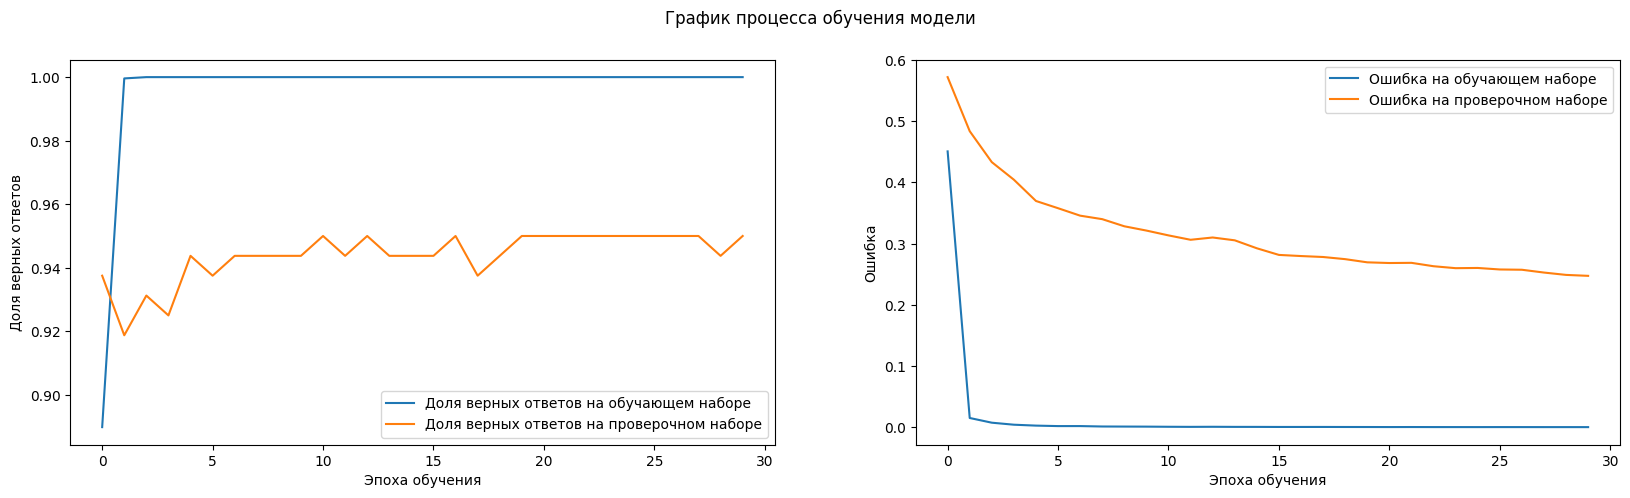

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


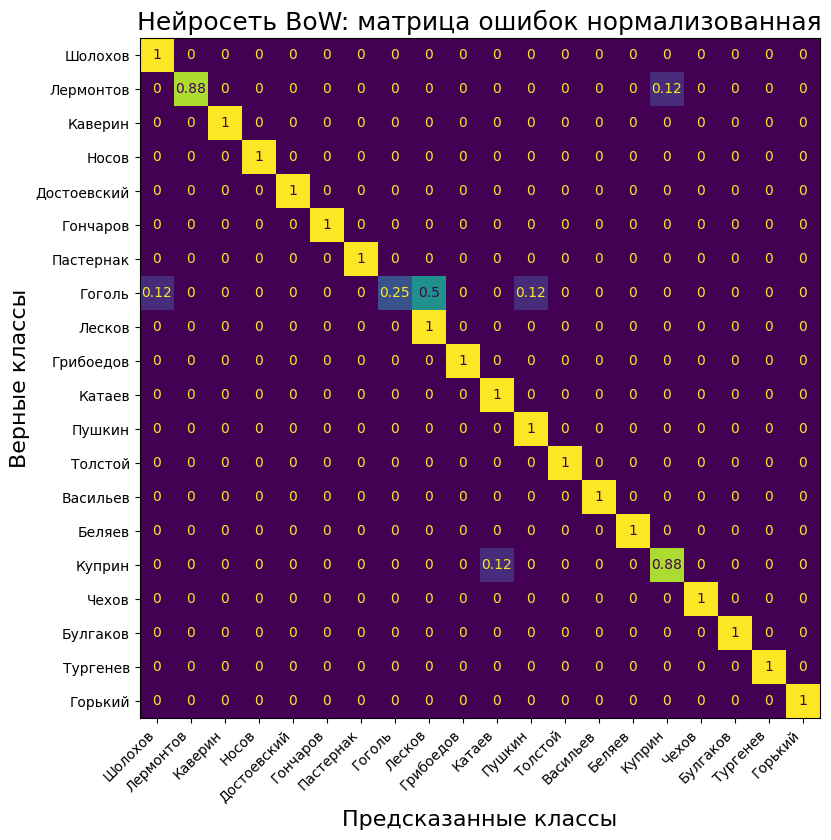

----------------------------------------------------------------------------------------------------
Нейросеть: BoW
Класс: Шолохов              100% сеть отнесла к классу Шолохов              - ВЕРНО :-)
Класс: Лермонтов             88% сеть отнесла к классу Лермонтов            - ВЕРНО :-)
Класс: Каверин              100% сеть отнесла к классу Каверин              - ВЕРНО :-)
Класс: Носов                100% сеть отнесла к классу Носов                - ВЕРНО :-)
Класс: Достоевский          100% сеть отнесла к классу Достоевский          - ВЕРНО :-)
Класс: Гончаров             100% сеть отнесла к классу Гончаров             - ВЕРНО :-)
Класс: Пастернак            100% сеть отнесла к классу Пастернак            - ВЕРНО :-)
Класс: Гоголь                50% сеть отнесла к классу Лесков               - НЕВЕРНО :-(
Класс: Лесков               100% сеть отнесла к классу Лесков               - ВЕРНО :-)
Класс: Грибоедов            100% сеть отнесла к классу Грибоедов            - ВЕРНО :-)
Кл

In [19]:
# Создаем модель для Bag of Words
bow_model = create_bow_model(VOCAB_SIZE, CLASS_COUNT)
compile_train_eval_model(bow_model,
                         x_train, y_train,
                         x_test, y_test,
                         class_labels=CLASS_LIST,
                         batch_size=24,
                         epochs=30,
                         optimizer=Adam(learning_rate=0.0009),
                         title='BoW')

Создание и тестирование модели на основе Embedding:

--- Calling create_embedding_model()...


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 382ms/step - accuracy: 0.0691 - loss: 4.0984 - val_accuracy: 0.0500 - val_loss: 2.9535
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.3999 - loss: 2.2703 - val_accuracy: 0.1375 - val_loss: 2.9164
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.9747 - loss: 0.2060 - val_accuracy: 0.2188 - val_loss: 2.7809
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9939 - loss: 0.0447 - val_accuracy: 0.2125 - val_loss: 2.7317
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9981 - loss: 0.0193 - val_accuracy: 0.2500 - val_loss: 2.6779
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.9975 - loss: 0.0208 - val_accuracy: 0.2562 - val_loss: 2.6147
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.9990 - loss: 0.0087 - val_accuracy: 0.2750 - val_loss: 2.5717
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.9990 - loss: 0.0084 - val_accuracy: 0.3063 -

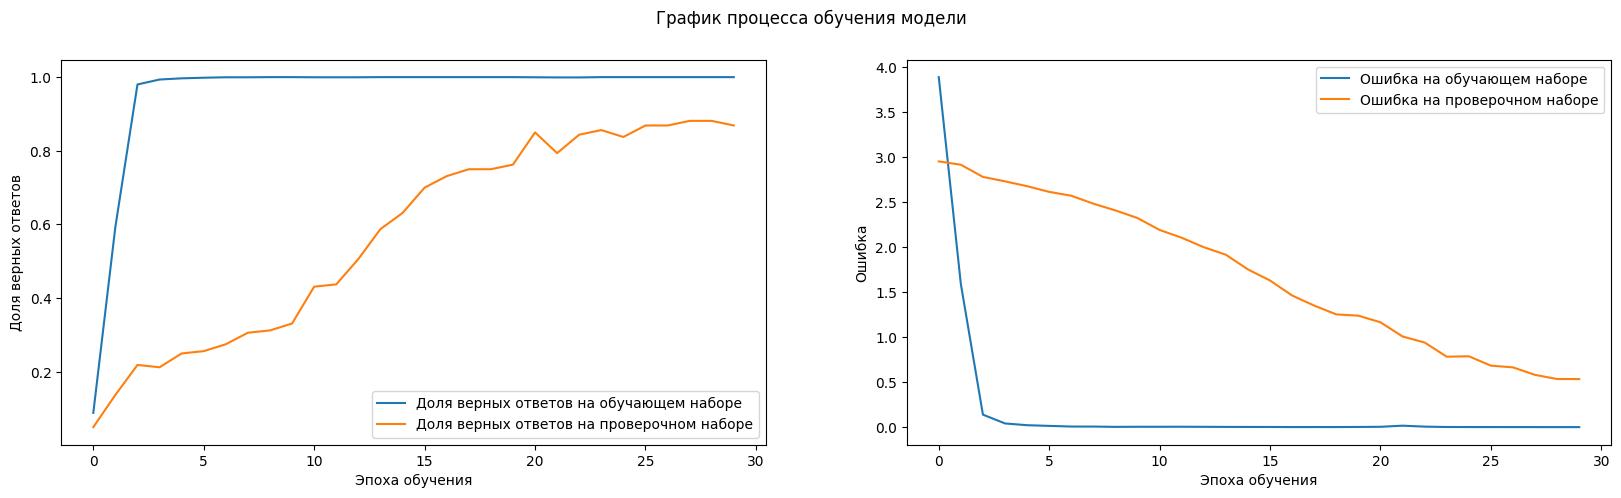

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  


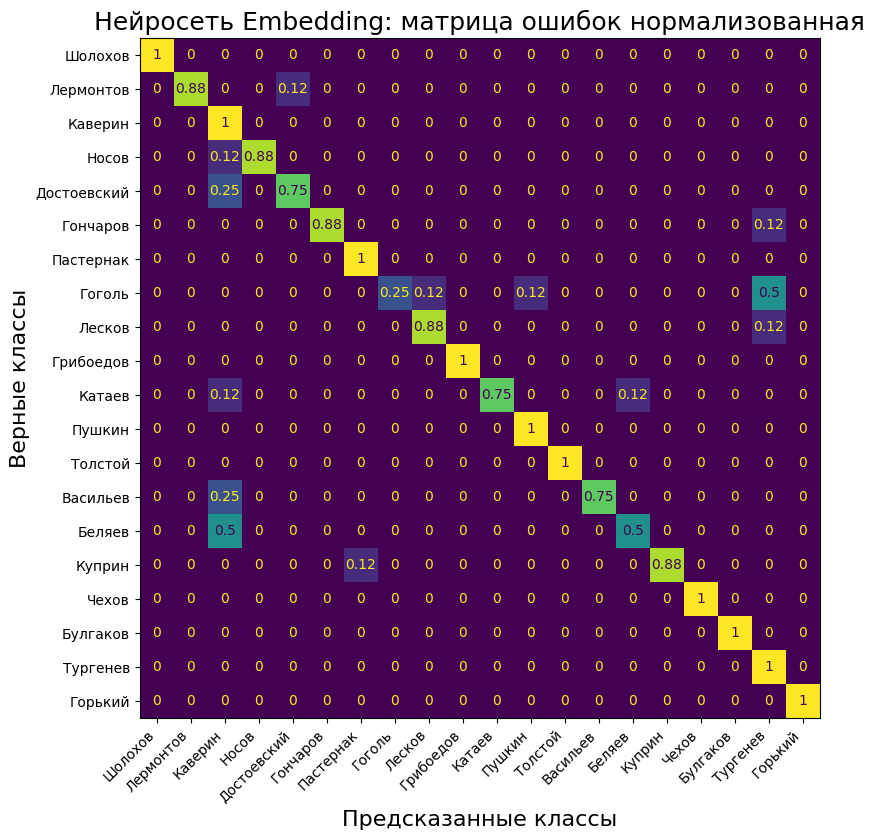

----------------------------------------------------------------------------------------------------
Нейросеть: Embedding
Класс: Шолохов              100% сеть отнесла к классу Шолохов              - ВЕРНО :-)
Класс: Лермонтов             88% сеть отнесла к классу Лермонтов            - ВЕРНО :-)
Класс: Каверин              100% сеть отнесла к классу Каверин              - ВЕРНО :-)
Класс: Носов                 88% сеть отнесла к классу Носов                - ВЕРНО :-)
Класс: Достоевский           75% сеть отнесла к классу Достоевский          - ВЕРНО :-)
Класс: Гончаров              88% сеть отнесла к классу Гончаров             - ВЕРНО :-)
Класс: Пастернак            100% сеть отнесла к классу Пастернак            - ВЕРНО :-)
Класс: Гоголь                50% сеть отнесла к классу Тургенев             - НЕВЕРНО :-(
Класс: Лесков                88% сеть отнесла к классу Лесков               - ВЕРНО :-)
Класс: Грибоедов            100% сеть отнесла к классу Грибоедов            - ВЕРНО 

In [20]:
# Создаем модель для Bag of Words
emb_model = create_embedding_model(VOCAB_SIZE, CLASS_COUNT)
compile_train_eval_model(emb_model,
                         x_train, y_train,
                         x_test, y_test,
                         class_labels=CLASS_LIST,
                         epochs=30,
                         title='Embedding')